In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from matplotlib.colors import ListedColormap
from sklearn.feature_selection import RFE , f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
import joblib

In [25]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
import math
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Reshape, BatchNormalization
from tensorflow.keras.models import load_model
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [3]:

df_train = pd.read_csv('dataset/Training.csv')
df_test = pd.read_csv('dataset/Testing.csv')
df_eksternal = pd.read_csv('dataset/data2.csv')
df_temp = pd.concat([df_train, df_test], ignore_index=True)
df = pd.concat([df_temp, df_eksternal], ignore_index=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3536 entries, 0 to 3535
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               3536 non-null   int64  
 1   Glucose                   3536 non-null   int64  
 2   BloodPressure             3536 non-null   int64  
 3   SkinThickness             3536 non-null   int64  
 4   Insulin                   3536 non-null   int64  
 5   BMI                       3536 non-null   float64
 6   DiabetesPedigreeFunction  3536 non-null   float64
 7   Age                       3536 non-null   int64  
 8   Outcome                   3536 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 248.8 KB


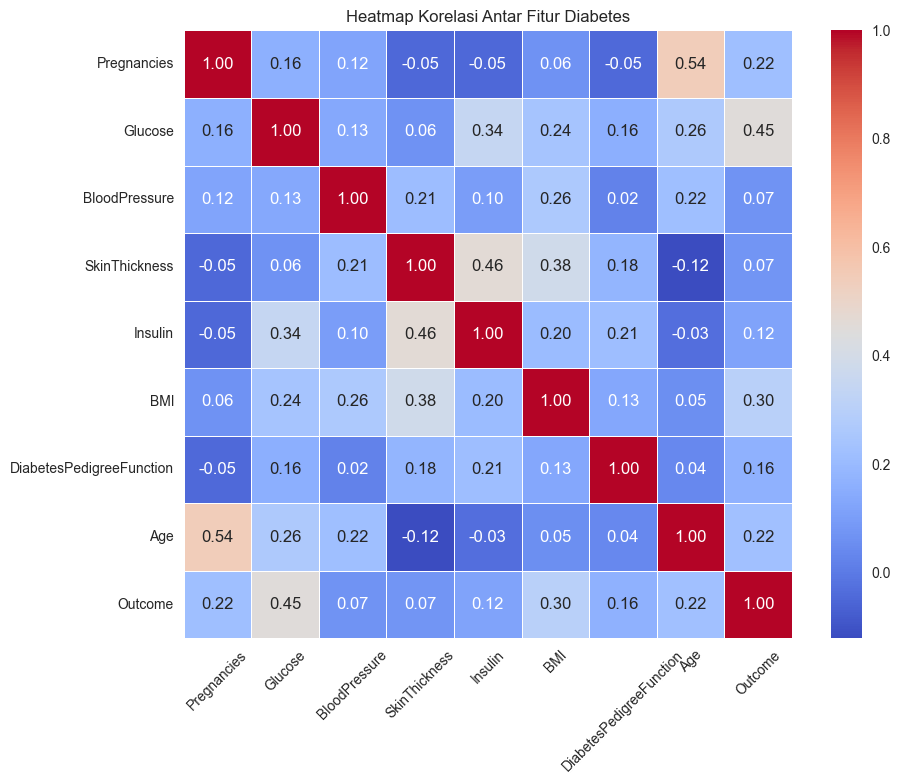

In [4]:
corr_matrix = df.corr(numeric_only=True) 

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    square=True
)
plt.title('Heatmap Korelasi Antar Fitur Diabetes')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [5]:
# Replace zero with NaN in some columns
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_replace] = df[cols_to_replace].replace(0, np.nan)
df.isnull().sum()

Pregnancies                    0
Glucose                       23
BloodPressure                163
SkinThickness               1037
Insulin                     1707
BMI                           46
DiabetesPedigreeFunction       0
Age                            0
Outcome                        0
dtype: int64

In [6]:
# metode interpolate
df = df.interpolate(method='linear', limit_direction='both')
print(df.isnull().sum())
df.dropna(inplace=True)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [7]:
def remove_outliers_iqr(df, target_column=None):
    if target_column:
        features = df.drop(columns=[target_column])
    else:
        features = df.copy()
        
    Q1 = features.quantile(0.25)
    Q3 = features.quantile(0.75)
    IQR = Q3 - Q1

    # Mask: data yang TIDAK outlier
    mask = ~((features < (Q1 - 1.5 * IQR)) | (features > (Q3 + 1.5 * IQR))).any(axis=1)

    # Gabungkan kembali kolom target kalau ada
    if target_column:
        return df.loc[mask]
    else:
        return features.loc[mask]

In [8]:
# Feature and label
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Menggabungkan fitur dan target
df_full = pd.concat([X, y], axis=1)

# Hapus outlier
df_no_outlier = remove_outliers_iqr(df_full, target_column="Outcome")

# Pisahkan kembali
X = df_no_outlier.drop("Outcome", axis=1)
y = df_no_outlier["Outcome"]

print(f"Data sebelum: {len(df_full)}")
print(f"Data setelah hapus outlier: {len(df_no_outlier)}")



Data sebelum: 3536
Data setelah hapus outlier: 3072


In [9]:
# Log transform
cols_to_log = ["Insulin", "DiabetesPedigreeFunction", "Age", "Pregnancies"]
for col in cols_to_log:
    X[col] = np.log1p(X[col])

# Scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Reshape for CNN: (samples, height, width, channels)
n_features = X.shape[1]
target_size = math.ceil(np.sqrt(n_features)) ** 2  # cari kuadrat sempurna terdekat
padding_needed = target_size - n_features


# Tambahkan kolom dummy
for i in range(padding_needed):
    X[f'dummy_{i}'] = 0

# Normalisasi & reshape
X_scaled = scaler.fit_transform(X)
side_len = int(math.sqrt(target_size))  # sisi matriks (misal 3 utk 9 fitur)
X_reshaped = X_scaled.reshape(-1, side_len, side_len, 1)

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)


In [61]:
# Build CNN model
model = Sequential([
    InputLayer(input_shape=(side_len, side_len, 1)),
    Conv2D(32, kernel_size=(2, 2), activation='relu'),
    Conv2D(64, kernel_size=(2, 2), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

early_stop = EarlyStopping(
    monitor='val_accuracy',    
    patience=5,             
    restore_best_weights=True
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/100
123/123 [==============================] - 1s 4ms/step - loss: 0.5359 - accuracy: 0.7120 - val_loss: 0.4616 - val_accuracy: 0.7419
Epoch 2/100
123/123 [==============================] - 0s 3ms/step - loss: 0.4708 - accuracy: 0.7567 - val_loss: 0.4489 - val_accuracy: 0.7459
Epoch 3/100
123/123 [==============================] - 0s 2ms/step - loss: 0.4616 - accuracy: 0.7735 - val_loss: 0.4463 - val_accuracy: 0.7459
Epoch 4/100
123/123 [==============================] - 0s 2ms/step - loss: 0.4433 - accuracy: 0.7827 - val_loss: 0.4254 - val_accuracy: 0.7724
Epoch 5/100
123/123 [==============================] - 0s 3ms/step - loss: 0.4306 - accuracy: 0.7975 - val_loss: 0.4150 - val_accuracy: 0.7764
Epoch 6/100
123/123 [==============================] - 0s 2ms/step - loss: 0.4161 - accuracy: 0.8081 - val_loss: 0.3974 - val_accuracy: 0.8028
Epoch 7/100
123/123 [==============================] - 0s 2ms/step - loss: 0.3963 - accuracy: 0.8148 - val_loss: 0.3877 - val_accuracy: 0.8089

In [63]:
# Evaluate model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.4).astype(int)

print("Akurasi:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 1ms/step
Akurasi: 0.9186991869918699
[[378  34]
 [ 16 187]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       412
           1       0.85      0.92      0.88       203

    accuracy                           0.92       615
   macro avg       0.90      0.92      0.91       615
weighted avg       0.92      0.92      0.92       615



20/20 [==============================] - 0s 1ms/step


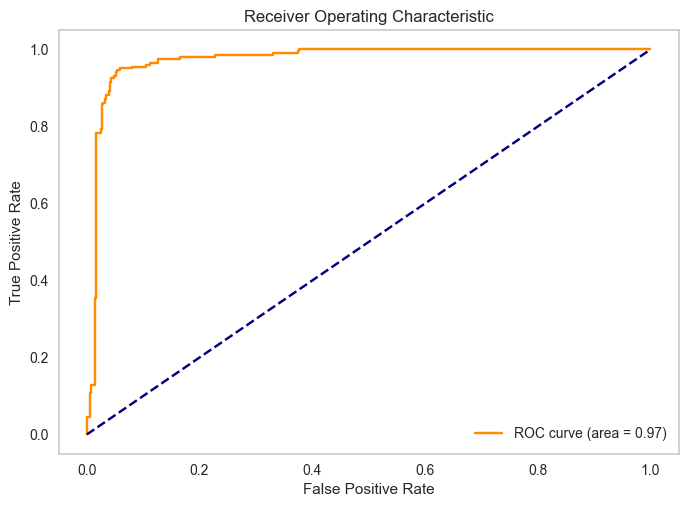

In [65]:


y_prob = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid()
plt.show()


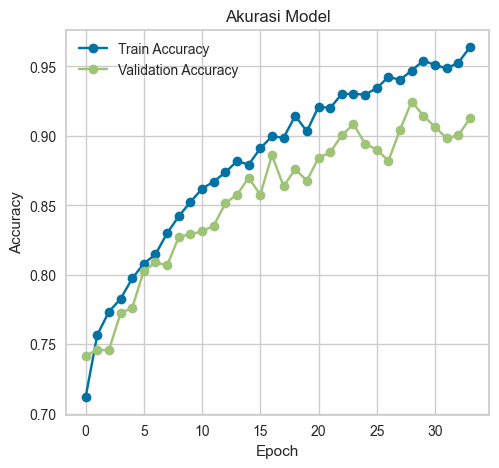

In [66]:
# === Plot Akurasi ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)




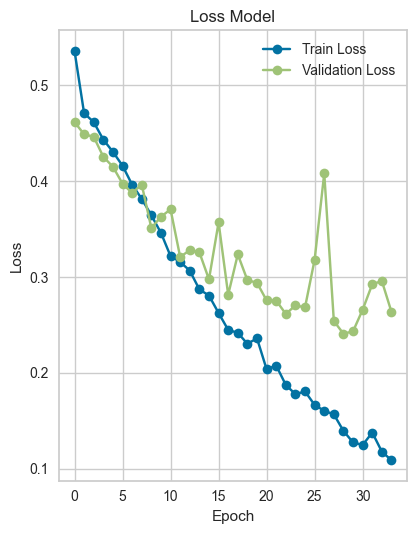

In [67]:
# === Plot Loss ===
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [68]:
model.save("saved_model/cnn_model.h5")
joblib.dump(scaler, 'saved_model/cnn_scaler.pkl')


C:\Users\COMPUTER WISA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['saved_model/cnn_scaler.pkl']

In [69]:

model = load_model("saved_model/cnn_model.h5")
scaler = joblib.load("saved_model/cnn_scaler.pkl")
# Data input
user_input = pd.DataFrame([
    # 1 outcome
    {'Pregnancies': 6, 'Glucose': 148, 'BloodPressure': 72, 'SkinThickness': 35, 'Insulin': 150, 'BMI': 33.6, 'DiabetesPedigreeFunction': 0.627, 'Age': 50},
    {'Pregnancies': 2, 'Glucose': 199, 'BloodPressure': 76, 'SkinThickness': 43, 'Insulin': 145, 'BMI': 42.9, 'DiabetesPedigreeFunction': 1.394, 'Age': 42},
    {'Pregnancies': 5, 'Glucose': 155, 'BloodPressure': 84, 'SkinThickness': 44, 'Insulin': 160, 'BMI': 38.7, 'DiabetesPedigreeFunction': 0.619, 'Age': 35},
    {'Pregnancies': 3, 'Glucose': 180, 'BloodPressure': 70, 'SkinThickness': 40, 'Insulin': 200, 'BMI': 36.5, 'DiabetesPedigreeFunction': 0.875, 'Age': 41},
    {'Pregnancies': 4, 'Glucose': 170, 'BloodPressure': 78, 'SkinThickness': 39, 'Insulin': 190, 'BMI': 37.8, 'DiabetesPedigreeFunction': 0.755, 'Age': 46},
    # 0.5 outcome
    {'Pregnancies': 3, 'Glucose': 120, 'BloodPressure': 70, 'SkinThickness': 30, 'Insulin': 100, 'BMI': 30.0, 'DiabetesPedigreeFunction': 0.45, 'Age': 33},
    {'Pregnancies': 2, 'Glucose': 125, 'BloodPressure': 72, 'SkinThickness': 28, 'Insulin': 105, 'BMI': 29.5, 'DiabetesPedigreeFunction': 0.5, 'Age': 35},
    {'Pregnancies': 4, 'Glucose': 115, 'BloodPressure': 74, 'SkinThickness': 32, 'Insulin': 110, 'BMI': 31.2, 'DiabetesPedigreeFunction': 0.48, 'Age': 37},
    # 0 outcome
    {'Pregnancies': 1, 'Glucose': 85, 'BloodPressure': 66, 'SkinThickness': 29, 'Insulin': 90, 'BMI': 26.6, 'DiabetesPedigreeFunction': 0.351, 'Age': 31},
    {'Pregnancies': 2, 'Glucose': 89, 'BloodPressure': 60, 'SkinThickness': 23, 'Insulin': 94, 'BMI': 28.1, 'DiabetesPedigreeFunction': 0.167, 'Age': 21},
    {'Pregnancies': 0, 'Glucose': 75, 'BloodPressure': 68, 'SkinThickness': 25, 'Insulin': 80, 'BMI': 24.2, 'DiabetesPedigreeFunction': 0.201, 'Age': 22},
    {'Pregnancies': 1, 'Glucose': 90, 'BloodPressure': 62, 'SkinThickness': 27, 'Insulin': 85, 'BMI': 25.3, 'DiabetesPedigreeFunction': 0.289, 'Age': 24},
    {'Pregnancies': 3, 'Glucose': 95, 'BloodPressure': 64, 'SkinThickness': 30, 'Insulin': 92, 'BMI': 27.9, 'DiabetesPedigreeFunction': 0.314, 'Age': 29},

])

# Transform log
cols_to_log = ["Insulin", "DiabetesPedigreeFunction", "Age", "Pregnancies"]
for col in cols_to_log:
    user_input[col] = np.log1p(user_input[col])

# Tambahkan dummy column agar jumlah fitur = 9 (sama seperti saat training)
user_input['dummy_0'] = 0

# Urutkan kolom agar sesuai dengan training
ordered_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                   'BMI', 'DiabetesPedigreeFunction', 'Age', 'dummy_0']
user_input = user_input[ordered_columns]

# Scaling
user_input_scaled = scaler.transform(user_input)

# Reshape ke format CNN
user_input_reshaped = user_input_scaled.reshape(-1, 3, 3, 1)

# Load dan prediksi

predictions = model.predict(user_input_reshaped)

# Tampilkan hasil
for i, p in enumerate(predictions):
    print(f"Data ke-{i+1} -> Probabilitas Diabetes: {p[0]*100:.2f}%")


1/1 [==============================] - 0s 68ms/step
Data ke-1 -> Probabilitas Diabetes: 94.76%
Data ke-2 -> Probabilitas Diabetes: 99.86%
Data ke-3 -> Probabilitas Diabetes: 96.59%
Data ke-4 -> Probabilitas Diabetes: 99.06%
Data ke-5 -> Probabilitas Diabetes: 98.98%
Data ke-6 -> Probabilitas Diabetes: 49.58%
Data ke-7 -> Probabilitas Diabetes: 66.30%
Data ke-8 -> Probabilitas Diabetes: 69.41%
Data ke-9 -> Probabilitas Diabetes: 0.00%
Data ke-10 -> Probabilitas Diabetes: 0.00%
Data ke-11 -> Probabilitas Diabetes: 0.00%
Data ke-12 -> Probabilitas Diabetes: 0.00%
Data ke-13 -> Probabilitas Diabetes: 5.13%
